# Agent Architecture: ReAct Agent

1. `Act`: The model calls a specific tool

2. `Observe`: Passes the tool's output back to the model

3. `Response`: Based on the output response from the tool and the input, the model will decide what to do in the next step

In [1]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper

In [2]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500) # get top 2 results and max 500 characters 
arxiv = ArxivQueryRun(api_wrapper = api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [3]:
arxiv.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [4]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=500) # get top 1 result and max 500 characters 
wiki = WikipediaQueryRun(api_wrapper = api_wrapper_wiki)
print(wiki.name)

wikipedia


In [5]:
wiki.invoke("What is Machine Learning?")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [6]:
from dotenv import load_dotenv
load_dotenv()
import os

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "ReAct_Agent"

In [9]:
# custom functions
def multiply(a: int, b: int) -> int:
    """Multiply a and b
    
    Args:
        a: first int
        b: second int
    """
    return a * b

def add(a: int, b: int) -> int:
    """Adds a and b
    
    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b
    
    Args:
        a: first int
        b: second int
    """
    return a / b


In [10]:
# Tavily search tool is a search engine built specially for AI agents delivering real time, accurate and factual results at speed 
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()
tavily.invoke("provide me recent AI news")

[{'title': 'The latest AI news we announced in June - Google Blog',
  'url': 'https://blog.google/technology/ai/google-ai-updates-june-2025/',
  'content': '# The latest AI news we announced in June\n\nJul 02, 2025\n\nHere’s a recap of some of our biggest AI updates from June, including more ways to search with AI Mode, a new way to share your NotebookLM notebooks publicly, and a new AI to help researchers better understand the human genome.\n\nSuperG\n\n## Basic explainer [...] For more than 20 years, we’ve invested in machine learning and AI research, tools and infrastructure to build products that make everyday life better for more people. Teams across Google are working on ways to unlock AI’s benefits in fields as wide-ranging as healthcare, crisis response and education. To keep you posted on our progress, we\'re doing a regular roundup of Google\'s most recent AI news.\n\nHere’s a look back at some of our AI announcements from June. [...] a text card reading "AI to revolutionize 

In [11]:
tools = [arxiv, wiki, tavily, add, multiply, divide]

In [12]:
from langchain_groq import ChatGroq
llm = ChatGroq(model= "gemma2-9b-it")
llm_with_tools = llm.bind_tools(tools)

In [14]:
from pprint import pprint
from langchain_core.messages import HumanMessage, AIMessage

llm_with_tools.invoke([HumanMessage(content = "What is recent ai news w.r.t 21st july 2025?")]).tool_calls


[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent ai news july 21st 2025'},
  'id': 'sb5bde4h3',
  'type': 'tool_call'}]

In [15]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [16]:
from IPython.display import display, Image
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

In [17]:
def tool_calling_llm(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

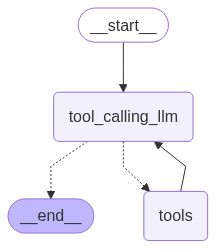

In [18]:
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition)
builder.add_edge("tools", "tool_calling_llm")

graph = builder.compile()

# view
display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
messages = graph.invoke({"messages":HumanMessage(content="Provide me top 10 recent AI news in year 2025. ")})
for m in messages['messages']: 
    m.pretty_print()

================================ Human Message =================================

Provide me top 10 recent AI news in year 2025. 
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (pd3q0heba)
 Call ID: pd3q0heba
  Args:
    query: top 10 recent AI news 2025
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "The latest AI news we announced in June - Google Blog", "url": "https://blog.google/technology/ai/google-ai-updates-june-2025/", "content": "# The latest AI news we announced in June\n\nJul 02, 2025\n\nHere’s a recap of some of our biggest AI updates from June, including more ways to search with AI Mode, a new way to share your NotebookLM notebooks publicly, and a new AI to help researchers better understand the human genome.\n\nSuperG\n\n## Basic explainer", "score": 0.8568246}, {"title": "12 Graphs That Explain the State of AI in 2025 

In [26]:
messages = graph.invoke({"messages":HumanMessage(content="Provide me the most recent AI news for 15 july 2025. Add 5 with 5 and then multiply the sum by 3")})
for m in messages['messages']: 
    m.pretty_print()

================================ Human Message =================================

Provide me the most recent AI news for 15 july 2025. Add 5 with 5 and then multiply the sum by 3
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (19cgte7es)
 Call ID: 19cgte7es
  Args:
    query: AI news 15 july 2025
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Latest AI Breakthroughs and News: May, June, July 2025", "url": "https://www.crescendo.ai/news/latest-ai-news-and-updates", "content": "### Pentagon Taps 4 Tech Firms to Expand Military AI Capabilities\n\nDate: July 15, 2025\n\nSummary: The U.S. Department of Defense has partnered with four commercial tech companies to accelerate AI integration into military operations. The contracts focus on logistics automation, battlefield decision support, and threat analysis. Officials say rapid deployment 

## Agent Memory
Let us introduce Agent with Memory

In [27]:
messages = graph.invoke({"messages":HumanMessage(content="5 plus 9, then divide the sum by 2")})
for m in messages['messages']: 
    m.pretty_print()

================================ Human Message =================================

5 plus 9, then divide the sum by 2
================================== Ai Message ==================================
Tool Calls:
  add (e1zgf6egq)
 Call ID: e1zgf6egq
  Args:
    a: 5
    b: 9
================================= Tool Message =================================
Name: add

14
================================== Ai Message ==================================
Tool Calls:
  divide (d0cm609mb)
 Call ID: d0cm609mb
  Args:
    a: 14
    b: 2
================================= Tool Message =================================
Name: divide

7.0
================================== Ai Message ==================================

7.0


In [28]:
messages = [HumanMessage(content="multiply that by 5")]
messages = graph.invoke({"messages":messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

multiply that by 5
================================== Ai Message ==================================
Tool Calls:
  multiply (kwq8n3tt1)
 Call ID: kwq8n3tt1
  Args:
    a: 10
    b: 5
================================= Tool Message =================================
Name: multiply

50
================================== Ai Message ==================================
Tool Calls:
  add (nqaqx899p)
 Call ID: nqaqx899p
  Args:
    a: 50
    b: 25
================================= Tool Message =================================
Name: add

75
================================== Ai Message ==================================

75


This way we do not get the desired output as out agent is not saving any memory of previous invokation. <br>
For implementing memory, we use a component called `MemorySaver` in langgraph

### MemorySaver
LangGraph can use a checkpointer to automatically save the graph state after each step. <br><br>
This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update. <br><br>
One of the easiest checkpointers to use is the MemorySaver, an in-memory key-value store for Graph State. <br><br>
All we need to do is compile our graph with a checkpointer, and our grpah is ready with memory. <br><br>

In [29]:
from IPython.display import display, Image
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

def tool_calling_llm(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}
    
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition)
builder.add_edge("tools", "tool_calling_llm")



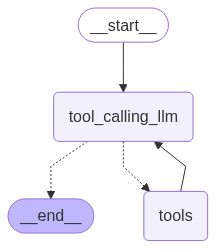

In [30]:
from langgraph.checkpoint.memory import MemorySaver 
memory = MemorySaver()
graph_memory = builder.compile(checkpointer=memory)

# view
display(Image(graph.get_graph().draw_mermaid_png()))

In [35]:
# specify the thread
config = {"configurable":{"thread_id":"1"}}

# specify the input
messages = [HumanMessage(content= "Add 12 and 13")]

messages = graph_memory.invoke({"messages": messages}, config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13
================================== Ai Message ==================================
Tool Calls:
  add (74agf26ye)
 Call ID: 74agf26ye
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

25


In [36]:
messages = [HumanMessage(content= "Add that number to 25")]

messages = graph_memory.invoke({"messages": messages}, config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13
================================== Ai Message ==================================
Tool Calls:
  add (74agf26ye)
 Call ID: 74agf26ye
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

25
================================ Human Message =================================

Add that number to 25
================================== Ai Message ==================================
Tool Calls:
  add (0nvc2fc92)
 Call ID: 0nvc2fc92
  Args:
    a: 25
    b: 25
================================= Tool Message =================================
Name: add

50
================================== Ai Message ==================================

50
